<a href="https://colab.research.google.com/github/ILoveCoder999/FederatedLearning/blob/master/dataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%%writefile /content/drive/MyDrive/preprocessing.py
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, random_split


class FederatedDataBuilder:
    def __init__(self, root='./data', val_split_ratio=0.1, K=100):

        self.root = root
        self.K = K
        self.val_split_ratio = val_split_ratio

        # Image transformations for DINO ViT (requires 224x224)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

        # Load CIFAR-100
        full_train_dataset = torchvision.datasets.CIFAR100(
            root=self.root, train=True, download=True, transform=self.transform
        )
        self.test_dataset = torchvision.datasets.CIFAR100(
            root=self.root, train=False, download=True, transform=self.transform
        )

        # Create train-validation split
        val_size = int(len(full_train_dataset) * val_split_ratio)
        train_size = len(full_train_dataset) - val_size

        self.train_dataset, self.val_dataset = random_split(
            full_train_dataset, [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )

        # Extract labels for Non-IID partitioning
        self.train_indices = self.train_dataset.indices
        self.train_targets = np.array(full_train_dataset.targets)[self.train_indices]

    def get_iid_partition(self):

        print(f"Creating IID partition for {self.K} clients...")

        num_items = int(len(self.train_dataset) / self.K)
        dict_users = {}
        all_idxs = list(range(len(self.train_dataset)))
        np.random.shuffle(all_idxs)

        for i in range(self.K):
            dict_users[i] = set(all_idxs[i * num_items : (i + 1) * num_items])

        return dict_users

    def get_non_iid_partition(self, Nc):

        print(f"Creating Non-IID partition (Nc={Nc}) for {self.K} clients...")

        # Sort by labels
        idxs = np.arange(len(self.train_dataset))
        labels = self.train_targets
        idxs_labels = np.vstack((idxs, labels))
        idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
        idxs = idxs_labels[0, :]

        # Create shards
        total_shards = self.K * Nc
        shard_size = int(len(self.train_dataset) / total_shards)
        idx_shard = [idxs[i*shard_size : (i+1)*shard_size] for i in range(total_shards)]

        # Assign shards to clients
        dict_users = {i: np.array([], dtype='int64') for i in range(self.K)}
        available_shards = list(range(total_shards))

        for i in range(self.K):
            for _ in range(Nc):
                shard_idx = np.random.choice(available_shards)
                dict_users[i] = np.concatenate((dict_users[i], idx_shard[shard_idx]))
                available_shards.remove(shard_idx)

        return dict_users

    def verify_partition(self, dict_users):

        print("\n" + "="*50)
        print("Verifying Partition")
        print("="*50)

        # Check 1: Total samples
        all_indices = set()
        for client_indices in dict_users.values():
            all_indices.update(client_indices)

        total = len(all_indices)
        expected = len(self.train_dataset)
        print(f"Total samples: {total}/{expected}")

        # Check 2: No overlap
        sum_samples = sum(len(indices) for indices in dict_users.values())
        if sum_samples != total:
            print(f"✗ Overlap detected!")
            return False
        print(f"No overlap")

        # Check 3: Class distribution
        classes_per_client = []
        for client_indices in dict_users.values():
            if isinstance(client_indices, set):
                client_indices = list(client_indices)
            client_labels = self.train_targets[client_indices]
            num_classes = len(np.unique(client_labels))
            classes_per_client.append(num_classes)

        avg_classes = np.mean(classes_per_client)
        print(f"✓ Avg classes per client: {avg_classes:.1f}")
        print("="*50 + "\n")

        return total == expected

    def visualize_distribution(self, dict_users, save_path=None, title=""):

        num_clients = len(dict_users)
        num_classes = 100

        # Build distribution matrix
        matrix = np.zeros((num_clients, num_classes))

        for client_id, client_indices in dict_users.items():
            if isinstance(client_indices, set):
                client_indices = list(client_indices)

            client_labels = self.train_targets[client_indices]
            unique_classes, counts = np.unique(client_labels, return_counts=True)

            for cls, count in zip(unique_classes, counts):
                matrix[client_id, cls] = count

        # Plot
        plt.figure(figsize=(12, 6))
        plt.imshow(matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
        plt.colorbar(label='Number of Samples')
        plt.xlabel('Class ID', fontsize=12)
        plt.ylabel('Client ID', fontsize=12)
        plt.title(f'Data Distribution - {title}', fontsize=14)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Figure saved to {save_path}")

        plt.show()




Writing /content/drive/MyDrive/preprocessing.py


100%|██████████| 169M/169M [00:03<00:00, 54.5MB/s]


Creating IID partition for 100 clients...

Verifying Partition
Total samples: 45000/45000
No overlap
✓ Avg classes per client: 99.0

Figure saved to iid.png


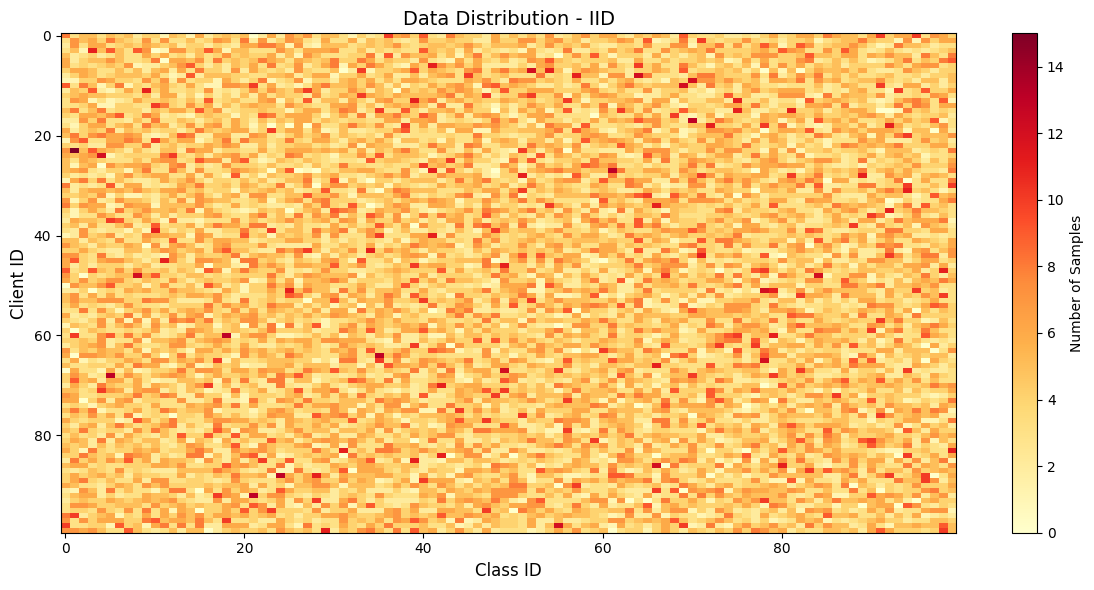

Creating Non-IID partition (Nc=5) for 100 clients...

Verifying Partition
Total samples: 45000/45000
No overlap
✓ Avg classes per client: 5.9

Figure saved to non_iid_nc5.png


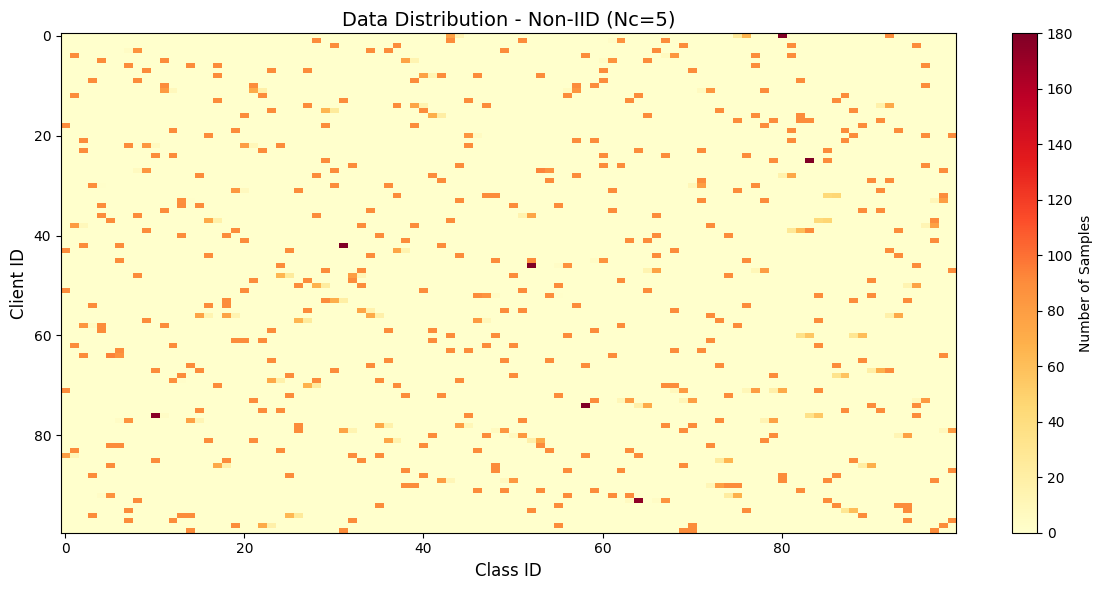

In [3]:
# test
if __name__ == "__main__":
    # Initialize
    data_builder = FederatedDataBuilder(K=100)

    # IID partition
    dict_users_iid = data_builder.get_iid_partition()
    data_builder.verify_partition(dict_users_iid)
    data_builder.visualize_distribution(dict_users_iid,
                                       save_path='iid.png',
                                       title='IID')

    # Non-IID partition
    dict_users_nc5 = data_builder.get_non_iid_partition(Nc=5)
    data_builder.verify_partition(dict_users_nc5)
    data_builder.visualize_distribution(dict_users_nc5,
                                       save_path='non_iid_nc5.png',
                                       title='Non-IID (Nc=5)')